# MNIST Partial Questing - with Curves! For longer! With a different loss!

Using the newly calculated loss, what happens if we train for longer? Training does seem to matter now, and our loss was massive in the previous experiments examining a dedicated curve layer.

## Imports

In [1]:
import random

import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels, horizontal_kernel, vertical_kernel, \
    load_intermediate_labels, generate_intermediate_curve_labels, save_intermediate_labels

## Globals

In [2]:
MODEL_NAME = "./curve_partial_loss_longer.pth"

## Set Device to GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [4]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [5]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an Image

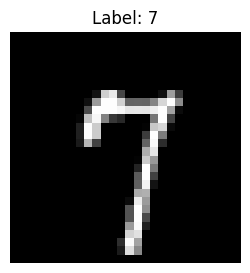

In [6]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Convolutions to get Horizontal Edges

### Example Image

In [7]:
horizontal_edges = get_edges(horizontal_kernel, sample_image)

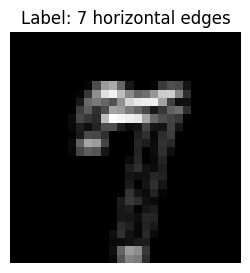

In [8]:
visualize_image(horizontal_edges, f"{sample_label} horizontal edges")

### Extending the Dataset

In [9]:
train_horizontal_image_labels = load_intermediate_labels("train_horizontal_image_labels.pkl")

In [10]:
val_horizontal_image_labels = load_intermediate_labels("val_horizontal_image_labels.pkl")

In [11]:
test_horizontal_image_labels = load_intermediate_labels("test_horizontal_image_labels.pkl")

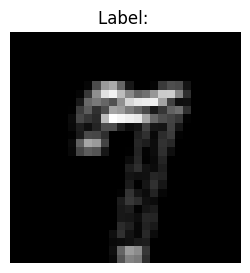

In [12]:
visualize_image(train_horizontal_image_labels[0].reshape(28, 28), "")

## Convolutions to get Vertical Edges

### Example Image

In [13]:
vertical_edges = get_edges(vertical_kernel, sample_image)

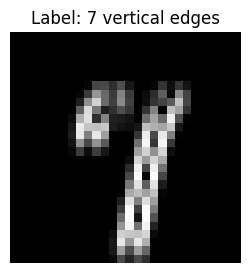

In [14]:
visualize_image(vertical_edges, f"{sample_label} vertical edges")

### Extending the Dataset

In [15]:
train_vertical_image_labels = load_intermediate_labels("train_vertical_image_labels.pkl")

In [16]:
val_vertical_image_labels = load_intermediate_labels("val_vertical_image_labels.pkl")

In [17]:
test_vertical_image_labels = load_intermediate_labels("test_vertical_image_labels.pkl")

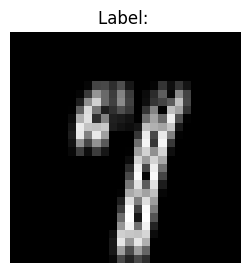

In [18]:
visualize_image(train_vertical_image_labels[0].reshape(28, 28), "")

## Convolutions to get Curves

Some extra steps here to generate better curves... this might be a point to re-visit in testing, but it largely comes from needing to rotate our curve kernel to capture curves.

The point to revisit is perhaps we want each unique rotation to be represented by an intermediate layer. Similar to how edges have been split into vertical and horizontal layers, perhaps we want layers to be dedicated to only one curve, instead of the culmination of curves.

### Example Image

In [19]:
curves = generate_intermediate_curve_labels([sample_image])

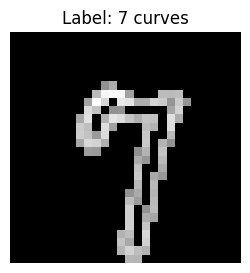

In [20]:
visualize_image(curves[0].reshape(28, 28), f"{sample_label} curves")

### Extending the dataset

In [21]:
train_curve_labels = load_intermediate_labels("train_curve_labels.pkl")

In [22]:
val_curve_labels = load_intermediate_labels("val_curve_labels.pkl")

In [23]:
test_curve_labels = load_intermediate_labels("test_curve_labels.pkl")

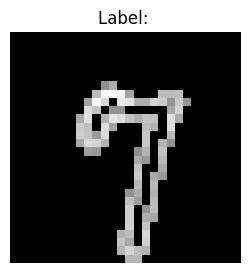

In [24]:
visualize_image(train_curve_labels[0].reshape(28, 28), "")

# Base Test

## Architecture

Updating the architecture to take into account our new curve layer.

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.curve_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal processing
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical processing
        vertical_out = self.vertical_layer(horizontal_act)
        vertical_act = self.activation_function(vertical_out)

        # curve processing
        curve_out = self.curve_layer(vertical_act)
        curve_act = self.activation_function(curve_out)

        # classification
        classification_out = self.classification_layer(curve_act)
        
        return classification_out, curve_act, vertical_act, horizontal_act

In [26]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [27]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()
horizontal_loss_fn = nn.MSELoss()
vertical_loss_fn = nn.MSELoss()
curve_loss_fn = nn.MSELoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [28]:
print(f"Model weights (to compare below): {model.horizontal_layer.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### Verify Reproducibility

In [29]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [30]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges, curves):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges
        self.curves = curves

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx]).float(),
            torch.tensor(self.labels[idx], dtype=torch.long),
            torch.from_numpy(self.horizontal_edges[idx]).float(),
            torch.from_numpy(self.vertical_edges[idx]).float(),
            torch.from_numpy(self.curves[idx]).float(),
        )

In [31]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [32]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels, train_curve_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels, val_curve_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels, test_curve_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Training Loop

In [33]:
num_epochs = 100
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels, horizontal_labels, vertical_labels, curve_labels = batch
        images, labels, horizontal_labels, vertical_labels, curve_labels = images.to(device), \
            labels.to(device), \
            horizontal_labels.to(device), \
            vertical_labels.to(device), \
            curve_labels.to(device)
        
        # forward pass
        classification_out, curve_act, vertical_act, horizontal_act = model(images)
        
        # --- Loss and Backprop ---

        # clear gradients
        optimizer.zero_grad()

        # curve_loss 
        curve_loss = curve_loss_fn(curve_act, curve_labels)
        
        # vertical loss
        vertical_loss = vertical_loss_fn(vertical_act, vertical_labels)

        # horizontal loss
        horizontal_loss = horizontal_loss_fn(horizontal_act, horizontal_labels)

        # classification loss
        classification_loss = classification_loss_fn(classification_out, labels)

        # total loss
        total_loss = curve_loss + vertical_loss + horizontal_loss + classification_loss
        total_loss.backward()
        
        optimizer.step()

        # update progress
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=classification_loss.item())

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels, horizontal_labels, vertical_labels, curve_labels = batch
            images, labels, horizontal_labels, vertical_labels, curve_labels = images.to(device), \
                labels.to(device), \
                horizontal_labels.to(device), \
                vertical_labels.to(device), \
                curve_labels.to(device)

            # forward pass
            classification_out, curve_act, vertical_act, horizontal_act = model(images)

            # curve_loss 
            curve_loss = curve_loss_fn(curve_act, curve_labels)
            
            # vertical loss
            vertical_loss = vertical_loss_fn(vertical_act, vertical_labels)
    
            # horizontal loss
            horizontal_loss = horizontal_loss_fn(horizontal_act, horizontal_labels)
    
            # classification loss
            classification_loss = classification_loss_fn(classification_out, labels)

            val_iter_loss = curve_loss + vertical_loss + horizontal_loss + classification_loss

            # calculate metrics
            val_loss += val_iter_loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_NAME)

Epoch 1/100
  Train Loss: 3580.4712
  Val Loss: 2947.7107 | Val Acc: 85.12%


Epoch 2/100
  Train Loss: 2754.4204
  Val Loss: 2641.4961 | Val Acc: 83.15%


Epoch 3/100
  Train Loss: 2531.2976
  Val Loss: 2489.5335 | Val Acc: 87.41%


Epoch 4/100
  Train Loss: 2413.7090
  Val Loss: 2392.4134 | Val Acc: 88.36%


Epoch 5/100
  Train Loss: 2344.2314
  Val Loss: 2323.5721 | Val Acc: 84.38%


Epoch 6/100
  Train Loss: 2291.4606
  Val Loss: 2293.2967 | Val Acc: 86.52%


Epoch 7/100
  Train Loss: 2254.3216
  Val Loss: 2273.7665 | Val Acc: 86.97%


Epoch 8/100
  Train Loss: 2226.4778
  Val Loss: 2237.8144 | Val Acc: 86.87%


Epoch 9/100
  Train Loss: 2206.2911
  Val Loss: 2234.7940 | Val Acc: 87.91%


Epoch 10/100
  Train Loss: 2187.8195
  Val Loss: 2211.0051 | Val Acc: 88.97%


Epoch 11/100
  Train Loss: 2175.7087
  Val Loss: 2196.1852 | Val Acc: 88.69%


Epoch 12/100
  Train Loss: 2164.5826
  Val Loss: 2188.5166 | Val Acc: 86.92%


Epoch 13/100
  Train Loss: 2156.0861
  Val Loss: 2182.8600 | Val Acc: 86.45%


Epoch 14/100
  Train Loss: 2146.5401
  Val Loss: 2179.3341 | Val Acc: 87.29%


Epoch 15/100
  Train Loss: 2138.2241
  Val Loss: 2166.7979 | Val Acc: 86.59%


Epoch 16/100
  Train Loss: 2132.8028
  Val Loss: 2174.4886 | Val Acc: 88.66%


Epoch 17/100
  Train Loss: 2126.3055
  Val Loss: 2156.9945 | Val Acc: 89.17%


Epoch 18/100
  Train Loss: 2121.1601
  Val Loss: 2139.9948 | Val Acc: 88.33%


Epoch 19/100
  Train Loss: 2115.2517
  Val Loss: 2153.4774 | Val Acc: 86.76%


Epoch 20/100
  Train Loss: 2112.4563
  Val Loss: 2122.2387 | Val Acc: 86.83%


Epoch 21/100
  Train Loss: 2107.3055
  Val Loss: 2137.3131 | Val Acc: 88.65%


Epoch 22/100
  Train Loss: 2100.6902
  Val Loss: 2131.3245 | Val Acc: 88.80%


Epoch 23/100
  Train Loss: 2097.2439
  Val Loss: 2135.2948 | Val Acc: 87.09%


Epoch 24/100
  Train Loss: 2094.8167
  Val Loss: 2122.0498 | Val Acc: 88.45%


Epoch 25/100
  Train Loss: 2092.2110
  Val Loss: 2129.4653 | Val Acc: 87.68%


Epoch 26/100
  Train Loss: 2087.4691
  Val Loss: 2124.4758 | Val Acc: 87.43%


Epoch 27/100
  Train Loss: 2083.9350
  Val Loss: 2120.1610 | Val Acc: 87.26%


Epoch 28/100
  Train Loss: 2084.2553
  Val Loss: 2110.1998 | Val Acc: 87.67%


Epoch 29/100
  Train Loss: 2080.6241
  Val Loss: 2139.9254 | Val Acc: 89.00%


Epoch 30/100
  Train Loss: 2081.3331
  Val Loss: 2115.2107 | Val Acc: 88.08%


Epoch 31/100
  Train Loss: 2076.8561
  Val Loss: 2106.4179 | Val Acc: 88.27%


Epoch 32/100
  Train Loss: 2075.3839
  Val Loss: 2099.2228 | Val Acc: 85.34%


Epoch 33/100
  Train Loss: 2075.7571
  Val Loss: 2098.0205 | Val Acc: 88.71%


Epoch 34/100
  Train Loss: 2070.3418
  Val Loss: 2123.7967 | Val Acc: 88.59%


Epoch 35/100
  Train Loss: 2070.3894
  Val Loss: 2097.5278 | Val Acc: 87.25%


Epoch 36/100
  Train Loss: 2070.5496
  Val Loss: 2111.5363 | Val Acc: 87.99%


Epoch 37/100
  Train Loss: 2065.7162
  Val Loss: 2101.3161 | Val Acc: 88.83%


Epoch 38/100
  Train Loss: 2065.2173
  Val Loss: 2112.3544 | Val Acc: 87.77%


Epoch 39/100
  Train Loss: 2062.7526
  Val Loss: 2105.2504 | Val Acc: 86.34%


Epoch 40/100
  Train Loss: 2062.4031
  Val Loss: 2092.7985 | Val Acc: 86.52%


Epoch 41/100
  Train Loss: 2057.3786
  Val Loss: 2091.9971 | Val Acc: 88.60%


Epoch 42/100
  Train Loss: 2061.2895
  Val Loss: 2102.5905 | Val Acc: 88.22%


Epoch 43/100
  Train Loss: 2058.2225
  Val Loss: 2095.4268 | Val Acc: 86.43%


Epoch 44/100
  Train Loss: 2056.1420
  Val Loss: 2099.1262 | Val Acc: 89.83%


Epoch 45/100
  Train Loss: 2054.9261
  Val Loss: 2087.4576 | Val Acc: 85.34%


Epoch 46/100
  Train Loss: 2055.1400
  Val Loss: 2097.3939 | Val Acc: 87.06%


Epoch 47/100
  Train Loss: 2053.7540
  Val Loss: 2098.5588 | Val Acc: 86.93%


Epoch 48/100
  Train Loss: 2052.5964
  Val Loss: 2103.1650 | Val Acc: 87.54%


Epoch 49/100
  Train Loss: 2051.3102
  Val Loss: 2105.4057 | Val Acc: 86.86%


Epoch 50/100
  Train Loss: 2051.6154
  Val Loss: 2082.3960 | Val Acc: 87.74%


Epoch 51/100
  Train Loss: 2050.7441
  Val Loss: 2092.3899 | Val Acc: 84.29%


Epoch 52/100
  Train Loss: 2049.0798
  Val Loss: 2106.3726 | Val Acc: 86.28%


Epoch 53/100
  Train Loss: 2048.0799
  Val Loss: 2099.5042 | Val Acc: 81.10%


Epoch 54/100
  Train Loss: 2047.9633
  Val Loss: 2080.5820 | Val Acc: 87.88%


Epoch 55/100
  Train Loss: 2048.2783
  Val Loss: 2081.4345 | Val Acc: 87.53%


Epoch 56/100
  Train Loss: 2045.0365
  Val Loss: 2066.1860 | Val Acc: 87.77%


Epoch 57/100
  Train Loss: 2045.2326
  Val Loss: 2092.8743 | Val Acc: 88.65%


Epoch 58/100
  Train Loss: 2046.6162
  Val Loss: 2094.9328 | Val Acc: 85.60%


Epoch 59/100
  Train Loss: 2037.8227
  Val Loss: 2089.1032 | Val Acc: 89.07%


Epoch 60/100
  Train Loss: 2040.0885
  Val Loss: 2067.3000 | Val Acc: 87.93%


Epoch 61/100
  Train Loss: 2039.0795
  Val Loss: 2073.5878 | Val Acc: 88.54%


Epoch 62/100
  Train Loss: 2037.9384
  Val Loss: 2076.6478 | Val Acc: 83.30%


Epoch 63/100
  Train Loss: 2035.4721
  Val Loss: 2070.8951 | Val Acc: 87.84%


Epoch 64/100
  Train Loss: 2033.2483
  Val Loss: 2072.7283 | Val Acc: 87.33%


Epoch 65/100
  Train Loss: 2034.8671
  Val Loss: 2087.6532 | Val Acc: 85.13%


Epoch 66/100
  Train Loss: 2033.6453
  Val Loss: 2079.3197 | Val Acc: 87.57%


Epoch 67/100
  Train Loss: 2034.3393
  Val Loss: 2066.9872 | Val Acc: 88.12%


Epoch 68/100
  Train Loss: 2031.7330
  Val Loss: 2078.9501 | Val Acc: 86.80%


Epoch 69/100
  Train Loss: 2032.6824
  Val Loss: 2080.7476 | Val Acc: 88.32%


Epoch 70/100
  Train Loss: 2033.7823
  Val Loss: 2071.4928 | Val Acc: 87.28%


Epoch 71/100
  Train Loss: 2030.1076
  Val Loss: 2068.2559 | Val Acc: 87.27%


Epoch 72/100
  Train Loss: 2030.8656
  Val Loss: 2063.4829 | Val Acc: 89.26%


Epoch 73/100
  Train Loss: 2029.2109
  Val Loss: 2081.3754 | Val Acc: 87.41%


Epoch 74/100
  Train Loss: 2029.1719
  Val Loss: 2084.2286 | Val Acc: 88.74%


Epoch 75/100
  Train Loss: 2028.7911
  Val Loss: 2081.6544 | Val Acc: 87.49%


Epoch 76/100
  Train Loss: 2026.6796
  Val Loss: 2066.7271 | Val Acc: 89.31%


Epoch 77/100
  Train Loss: 2026.6395
  Val Loss: 2088.6335 | Val Acc: 89.68%


Epoch 78/100
  Train Loss: 2026.8154
  Val Loss: 2070.4868 | Val Acc: 85.23%


Epoch 79/100
  Train Loss: 2024.8448
  Val Loss: 2072.7837 | Val Acc: 87.46%


Epoch 80/100
  Train Loss: 2026.0472
  Val Loss: 2055.1174 | Val Acc: 87.87%


Epoch 81/100
  Train Loss: 2023.1907
  Val Loss: 2055.6669 | Val Acc: 89.05%


Epoch 82/100
  Train Loss: 2024.6905
  Val Loss: 2073.9221 | Val Acc: 86.80%


Epoch 83/100
  Train Loss: 2023.0764
  Val Loss: 2071.2596 | Val Acc: 88.72%


Epoch 84/100
  Train Loss: 2022.7579
  Val Loss: 2055.1253 | Val Acc: 86.00%


Epoch 85/100
  Train Loss: 2022.1891
  Val Loss: 2083.6599 | Val Acc: 87.96%


Epoch 86/100
  Train Loss: 2021.8118
  Val Loss: 2063.4188 | Val Acc: 88.10%


Epoch 87/100
  Train Loss: 2019.8411
  Val Loss: 2052.8475 | Val Acc: 88.21%


Epoch 88/100
  Train Loss: 2020.0602
  Val Loss: 2086.0378 | Val Acc: 87.89%


Epoch 89/100
  Train Loss: 2020.4816
  Val Loss: 2078.3544 | Val Acc: 88.88%


Epoch 90/100
  Train Loss: 2020.2687
  Val Loss: 2065.8790 | Val Acc: 88.63%


Epoch 91/100
  Train Loss: 2019.7682
  Val Loss: 2079.1314 | Val Acc: 85.34%


Epoch 92/100
  Train Loss: 2017.9430
  Val Loss: 2068.4390 | Val Acc: 86.64%


Epoch 93/100
  Train Loss: 2020.0603
  Val Loss: 2052.6756 | Val Acc: 85.99%


Epoch 94/100
  Train Loss: 2017.8594
  Val Loss: 2057.2206 | Val Acc: 89.17%


Epoch 95/100
  Train Loss: 2014.8393
  Val Loss: 2058.9135 | Val Acc: 86.72%


Epoch 96/100
  Train Loss: 2018.0358
  Val Loss: 2095.7331 | Val Acc: 84.66%


Epoch 97/100
  Train Loss: 2018.3416
  Val Loss: 2059.9214 | Val Acc: 88.34%


Epoch 98/100
  Train Loss: 2017.5319
  Val Loss: 2055.3099 | Val Acc: 86.59%


Epoch 99/100
  Train Loss: 2018.7331
  Val Loss: 2085.6067 | Val Acc: 88.32%


Epoch 100/100
  Train Loss: 2016.3145
  Val Loss: 2077.2601 | Val Acc: 88.44%


## Eval

In [34]:
model.load_state_dict(torch.load(MODEL_NAME))
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(val_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels, _, _, _ = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _, _, _ = model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|█████████████████████████████████| 79/79 [00:00<00:00, 298.20it/s]

Final Test Accuracy: 85.99%


Longer training seems slightly worse. We are probably overfitting and/or catering far too much to the side quests in this case; however, this is still better to training with only using the classification loss during the validation loop to find the best model to use from training.

So, maybe these runs show that choosing the model with the best classification loss from validation isn't necesarily the correct choice. Which is... interesting, as you might expect the best answer on the main quest to still be the best overall model instead of the best answer on the main quest + the side quests.

# Exploring Model Results

## Visualizing Weights

In [35]:
horizontal_layer_weights = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

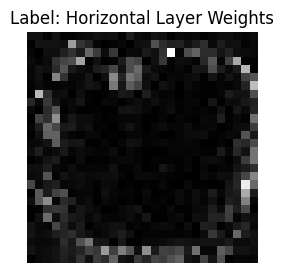

In [36]:
visualize_image(horizontal_layer_weights, "Horizontal Layer Weights")

In [37]:
vertical_layer_weights = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

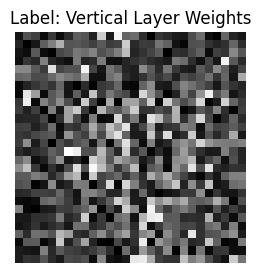

In [38]:
visualize_image(vertical_layer_weights, "Vertical Layer Weights")

In [39]:
curve_layer_weights = np.abs(model.curve_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

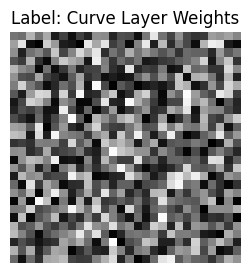

In [40]:
visualize_image(curve_layer_weights, "Curve Layer Weights")

In [41]:
classification_layer_weights = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

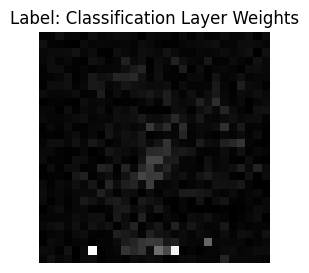

In [42]:
visualize_image(classification_layer_weights, "Classification Layer Weights")

I wonder if we can impose these intermediate features while still forcing a distribution of learning by the network. I get the feeling dead layers is not a good thing in the network, like layers of brain tissuing dying or being rendered useless.